<h1 style = "font-size:3rem;color:blue;"> Drifter Data Analysis</h1>



Data formatting for Biogeochemical Drifter field observations


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Read in data and parse by column header


In [3]:
filename = '80010503'

YSIfilename = 'May6YSIData'

fullname = filename+'.csv'

YSIfullname = YSIfilename+ '.csv'

filepath = os.path.join('D:', fullname) # PJB: changed from "'D', fullname" to "'Data', fullname"

YSIfilepath = os.path.join('D:', YSIfullname) # PJB: ditto


df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None, date_format = '%m/%d/%Y %H:%M:%S')

YSIdf = pd.read_csv(YSIfilepath, parse_dates = [[0, 1]], header = None, encoding = 'utf-16', skiprows = 17)
df.columns = ['time', 'elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'altitude', 'speed', 'angle', 'pH', 'Temperature (C)', 'DO (mg/L)', 'Conductivity (uS/cm)']

YSIdf.columns = ['Time',	'Time (Fract. Sec)',	'Site Name',	'Chlorophyll RFU',	'Cond µS/cm',	'Depth m',	'fDOM QSU',	'fDOM RFU',	'nLF Cond µS/cm',	'ODO % sat',	'ODO % local',	'ODO mg/L',	'Pressure psi a',	'Sal psu',	'SpCond µS/cm',	'TAL PE RFU',	'TDS mg/L',	'Turbidity FNU',	'TSS mg/L',	'pH',	'pH mV',	'Temp °C',	'Vertical Position m',	'GPS Latitude °',	'GPS Longitude °',	'Altitude m',	'Battery V',	'Cable Pwr V',	'Barometer mmHg']
 

#df = df.truncate(before= 250, copy = None)


df.head()

# YSIdf.head()



,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,altitude,speed,angle,pH,Temperature (C),DO (mg/L),Conductivity (uS/cm)
0,1/5/2080 23:59:43.875,2,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1,1/5/2080 23:59:45.875,4,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.69,38.16,6.60,59550.0
2,1/5/2080 23:59:47.875,6,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.43,38.17,3.04,23570.0
3,1/5/2080 23:59:49.875,8,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.39,38.19,3.04,23560.0
4,1/5/2080 23:59:51.875,10,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.37,38.20,3.04,23560.0


In [5]:
def lat_convert(lat_badfmt):
    """Convert latitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lat_badfmt = str(lat_badfmt)
        lat_DD = int(float(lat_badfmt) / 100)  # Extract degrees
        lat_MM = float(lat_badfmt) - lat_DD * 100  # Extract minutes
        return lat_DD + lat_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

def lon_convert(lon_badfmt):
    """Convert longitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lon_badfmt = str(lon_badfmt)
        lon_DD = int(float(lon_badfmt) / 100)  # Extract degrees
        lon_MM = float(lon_badfmt) - lon_DD * 100  # Extract minutes
        return lon_DD + lon_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

# Apply conversions
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# Fix South (negative latitudes)
df.loc[df['N or S'] == 'S', 'lat'] *= -1

# Fix West (negative longitudes)
df.loc[df['E or W'] == 'W', 'lon'] *= -1

# Check output
df.head()


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,altitude,speed,angle,pH,Temperature (C),DO (mg/L),Conductivity (uS/cm),lat,lon
0,1/5/2080 23:59:43.875,2,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0
1,1/5/2080 23:59:45.875,4,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.69,38.16,6.60,59550.0,0.0,0.0
2,1/5/2080 23:59:47.875,6,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.43,38.17,3.04,23570.0,0.0,0.0
3,1/5/2080 23:59:49.875,8,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.39,38.19,3.04,23560.0,0.0,0.0
4,1/5/2080 23:59:51.875,10,0.0,NaN,0.0,NaN,0.0,0.0,0.0,8.37,38.20,3.04,23560.0,0.0,0.0


In [9]:
def plot_gps_points(lon, lat):
     fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}) 
     stamen_terrain = cimgt.Stamen('terrain')
     ax.add_image(stamen_terrain, 8)
    
    # Plot the GPS points
     ax.plot(lon, lat, 'bo', markersize=5, transform=ccrs.PlateCarree())
    
    # Add gridlines
     gl = ax.gridlines(draw_labels=True)
     gl.xlabels_top = False
     gl.ylabels_right = False
     gl.xformatter = LONGITUDE_FORMATTER
     gl.yformatter = LATITUDE_FORMATTER
    
     plt.show(df.lon,df.lat)


In [ ]:
## Mapbox
map_id = 'streets-v11'
base_layer_mapbox = cimgt.MapboxTiles(mapbox_access_token, map_id=map_id)
tile_zoom_mapbox = 20
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

# Get desired variable
var_name = 'depth (cm)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

figname = filename + var_name+'.png'
figpath = os.path.join('Figs', figname)
# plt.savefig(figpath, dpi = 300) # (un)comment depending on preference for saving figure locally




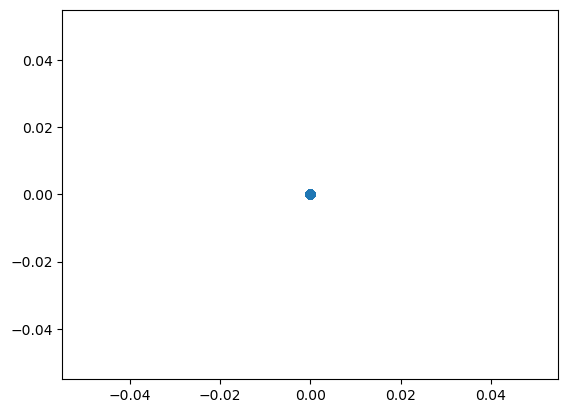

In [11]:
plt.scatter(df.lon, df.lat)


### Begin analyzing time-series data
Comparison between the Drifter time series of pH and the YSI EXO2s sonde.

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2025-03-24 20:59:43.875000'),
       Timestamp('2025-03-24 20:59:45.875000'),
       Timestamp('2025-03-24 20:59:47.875000'), ...,
       '5/7/2025 12:58:23.078', '5/7/2025 12:58:25.078',
       '5/7/2025 12:58:27.078'], dtype=object)

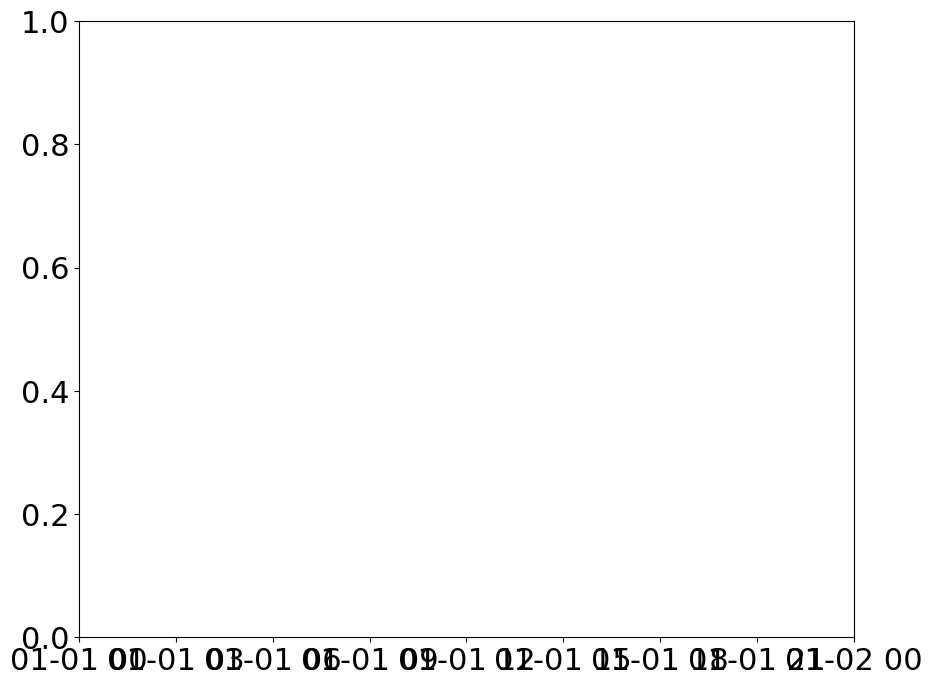

In [5]:
# time = df['time']  # No longer needed
ph = df['pH']       # Keep this
YSItime = YSIdf['Time']
YSIph = YSIdf['pH']
hours_to_add = 5
YSItime = YSItime + pd.Timedelta(hours= hours_to_add)

# Directly modify the 'time' column in df
df.loc[0:11533, 'time'] = pd.to_datetime(df.loc[0:11533, 'time']) + pd.Timedelta(-480243, "h")

time = df['time'] #create time after the modification

#time_in_need_of_adj = time.loc[0:11534]
#time_adj = pd.to_datetime(time_in_need_of_adj) + pd.Timedelta(-480243, "h")
#time_corr = time
#time_corr.loc[0:11534] = time_adj
#Drifter_hours_to_subract = 1
#Years_to_subract= 55
#months_to_add= 2
#time = pd.to_datetime(time) + pd.Timedelta(-480243, "h")

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access

plt.plot(time,ph, label = "Drifter")
plt.plot(YSItime,YSIph, label = "YSI")
plt.title('pH over time')
plt.xlabel('Time in Seconds')
plt.ylabel('pH')
axs.legend()
fig.autofmt_xdate()

# PJB: Stephen, add legend to graph


In [43]:
time_in_need_of_adj = time[0:500]
time_adj = pd.to_datetime(time_in_need_of_adj) + pd.Timedelta(-480243, "h")
time_corr = time
time_corr[0:500] = time_adj

250     2080-01-06 00:08:03.869
251     2080-01-06 00:08:05.869
252     2080-01-06 00:08:07.869
253     2080-01-06 00:08:09.869
254     2080-01-06 00:08:11.869
                  ...          
30075   2025-05-07 12:58:19.078
30076   2025-05-07 12:58:21.078
30077   2025-05-07 12:58:23.078
30078   2025-05-07 12:58:25.078
30079   2025-05-07 12:58:27.078
Name: time, Length: 29830, dtype: datetime64[ns]

### Analyze and visualize dissolved oxygen
Plot the DO measured by the drifter to that of the YSI EXO2s to determine the quality of the drifters readings

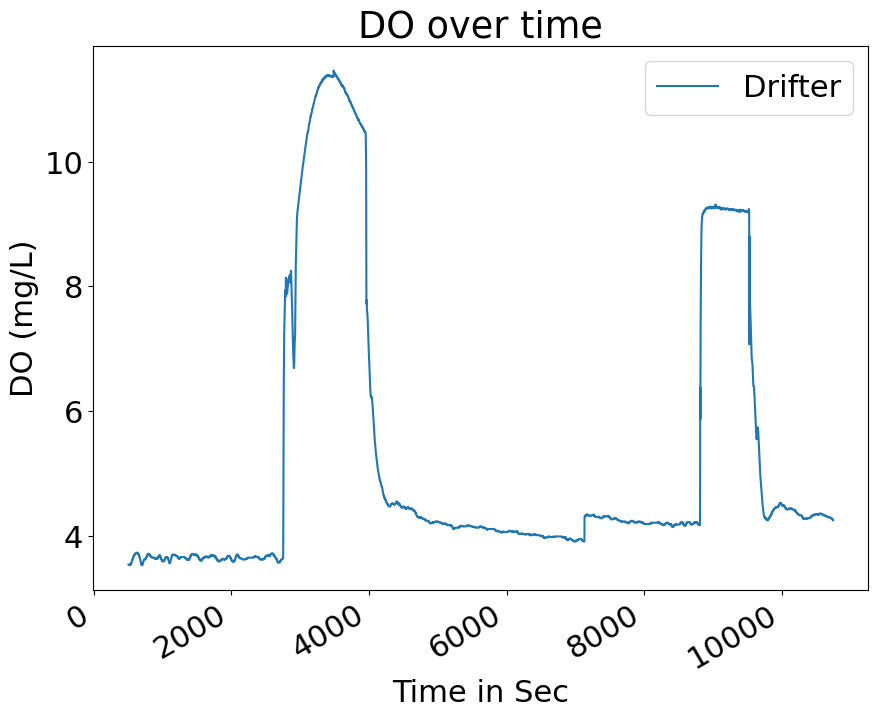

In [9]:
DO = df['DO (mg/L)']  #Use +5.9 as a one point calibration correction for the Drifter (DO(salt) = DO * k * S(ppt)
#YSIDO = YSIdf['ODO mg/L'] 

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,DO, label = 'Drifter')
#plt.plot(YSItime, YSIDO, label = 'YSI EXO2s')
plt.title('DO over time')
plt.xlabel('Time in Sec')
plt.ylabel('DO (mg/L)')
axs.legend()
fig.autofmt_xdate()

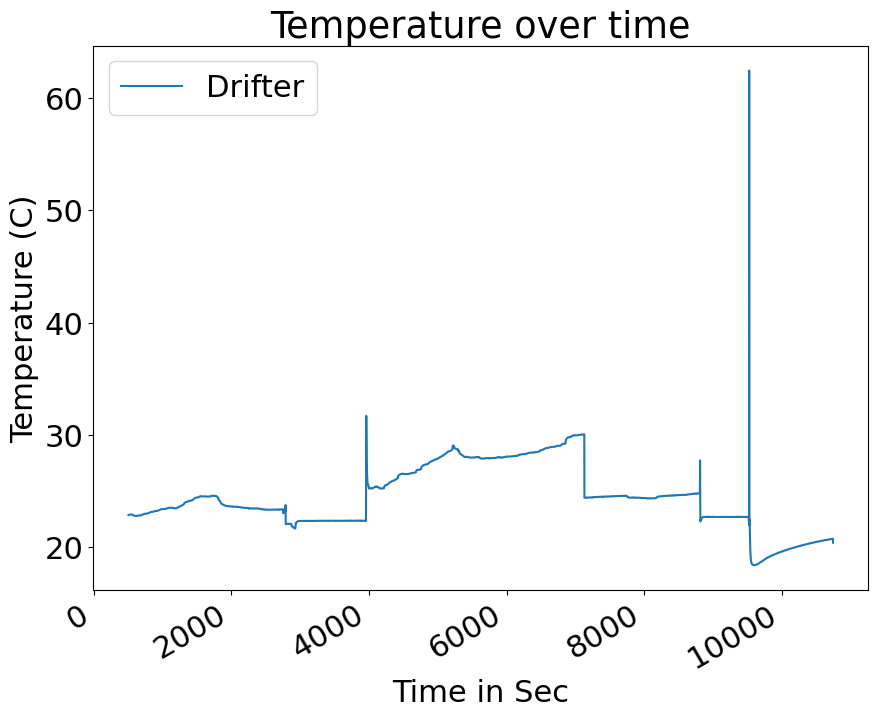

In [11]:
temp = df['Temperature (C)'] -3.6 #correct the temperature probe as much as possible 
#YSItemp = YSIdf['Temp °C']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,temp, label = 'Drifter')
#plt.plot(YSItime,YSItemp, label = 'YSI EXO2s')
plt.title('Temperature over time')
plt.xlabel('Time in Sec')
plt.ylabel('Temperature (C)')
axs.legend()
fig.autofmt_xdate()

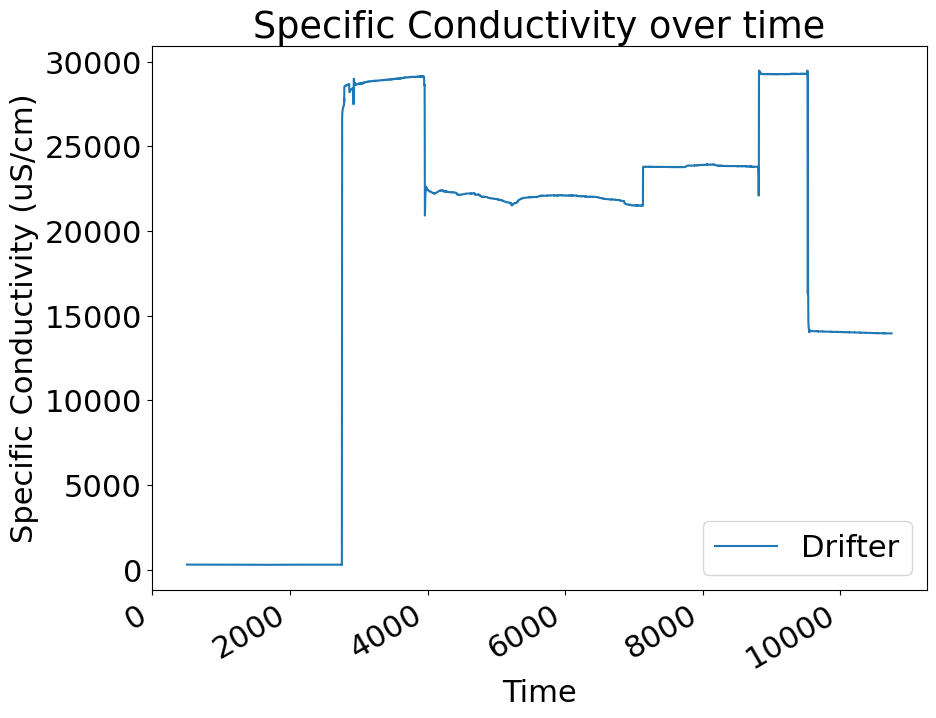

In [13]:
spcond = df['Conductivity (uS/cm)'] #point calibration for drifter
#YSIspcond = YSIdf['SpCond µS/cm']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,spcond, label = 'Drifter')
#plt.plot(YSItime,YSIspcond, label = 'YSI EXO2s')
plt.title('Specific Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Specific Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()

In [ ]:
#interpolation section

Drifter_on_YSI_time = np.interp(YSItime, # new timestamp
                                        df.loc[:, 'time'],         # old timestamp
                                        df.loc[:, 'DO (mg/L)'],   # old data
                                        left = np.nan, right = np.nan)

Drifter_minus_YSI_anomaly = Drifter_on_YSI_time-YSIdf.loc[:, 'ODO mg/L']

Drifter_on_YSI_time

### NOTE: 
Cutting rmse calculation, print statement, and plotting out of cell above and into new cell below. Given hard to understand results (i.e., "nan"), print out variables to examine in more detail before proceeding with analysis.

First variable I printed as output to cell above (`Drifter_on_YSI_time`) suggests that it *might* be filled with NaNs. We'd want to dig deeper to confirm whether it was *all* NaNs or just some, but without going further down that route, I can immediately see an issue with the timestamps that you are using here. You created a new time variable for the YSI above to align it with the Drifter's time(zone) but then didn't use it here! Use the matching/aligned times here next and see what happens.

In [ ]:
rmse_drifter = np.sqrt(np.sum((Drifter_minus_YSI_anomaly)**2)/(len(Drifter_minus_YSI_anomaly)))

print(np.nanmean(Drifter_minus_YSI_anomaly), np.nanstd(Drifter_minus_YSI_anomaly), rmse_drifter)

plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize=(20, 15), nrows = 2, sharex = True)

# Plot YSI EXO2s oxygen data
axs[0].plot(YSItime, YSIdf.loc[:, 'ODO mg/L'], '-', label="YSI EXO2s", linewidth=5)

# Plot Drifter DO data
axs[0].plot(df.loc[:, 'time'], df.loc[:, 'DO (mg/L)'], 'ro', label="Drifter", markersize = 5)

### Describe
After repeating this for your variables of interest, describe what you see and what could be going on. Dig deeper into the sensor manuals (especially the Atlas sensors) to (1) confirm you're comparing apples to apples (e.g., conductivity to conductivity, not conductivity to specific conductivity, for instance), (2) understand why there might be offsets/differing variability, (3) determine whether more can be done to get the values to come closer to agreeing. For (3), examples might include: additional calculations to ensure you're comparing apples to apples, calibration checks following Atlas's recommendations or other options that we can discuss, etc. 

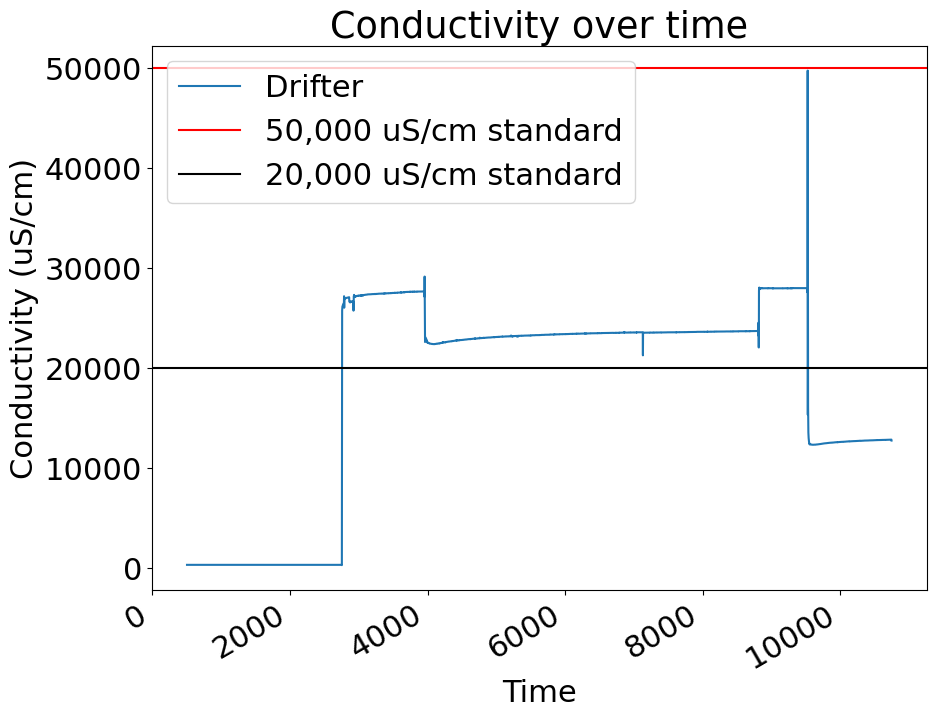

In [15]:

r = 0.0191 #taken from https://in-situ.com/uk/pub/media/support/documents/Specific-Conductance-as-an-Output-Unit-for-Conductivity-Readings-Tech-Note.pdf?srsltid=AfmBOorCrC34rz2-u7FivCA1360XG7FOcGRU4EQ4-8JsYUYBz3V8cfu0
acond = spcond*(1+r*(temp-25))
#YSIcond = YSIdf['Cond µS/cm']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,acond, label = 'Drifter')
plt.axhline( y = 50000, color = 'r', label = '50,000 uS/cm standard')
plt.axhline( y = 20000, color = 'k', label = '20,000 uS/cm standard')
#plt.plot(YSItime,YSIcond, label = 'YSI EXO2s')
plt.title('Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()



                

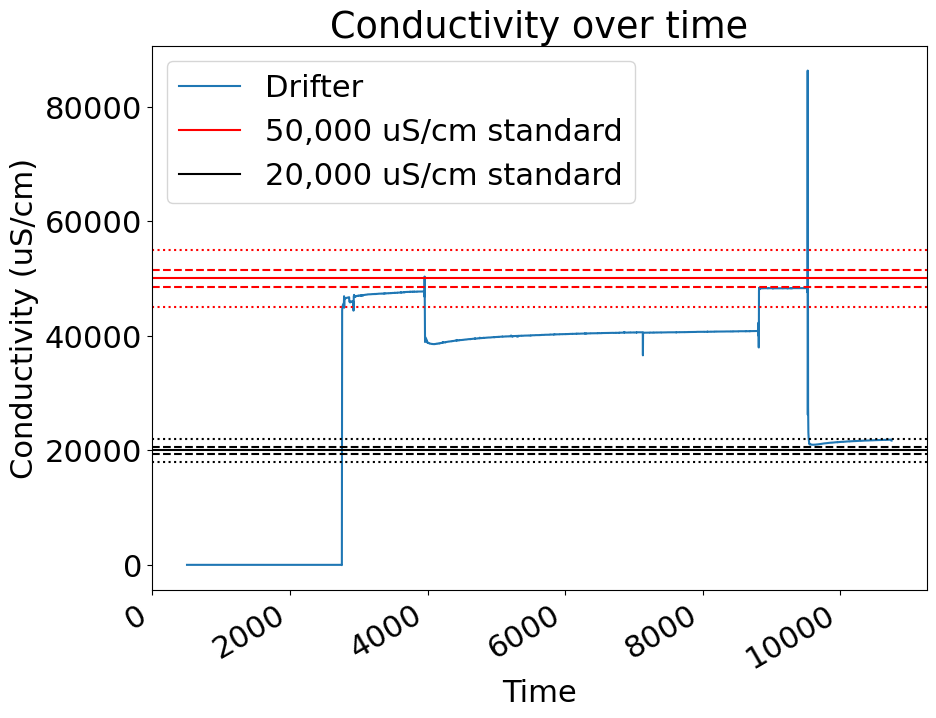

In [25]:
cond_corrected = (acond-290.85)/0.5732 #calculated via 2 point calibration standard

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time, cond_corrected, label = 'Drifter')
plt.axhline( y = 50000, color = 'r', label = '50,000 uS/cm standard')
plt.axhline( y = 51500, color = 'r', linestyle = '--')
plt.axhline (y = 48500, color = 'r', linestyle = '--')
plt.axhline (y = 45000, color = 'r', linestyle = ':')
plt.axhline (y = 55000, color = 'r', linestyle = ':')
plt.axhline( y = 20000, color = 'k', label = '20,000 uS/cm standard')
plt.axhline( y = 20600, color = 'k', linestyle = '--')
plt.axhline (y = 19400, color = 'k', linestyle = '--')
plt.axhline (y = 18000, color = 'k', linestyle = ':')
plt.axhline (y = 22000, color = 'k', linestyle = ':')

#plt.plot(YSItime,YSIcond, label = 'YSI EXO2s')
plt.title('Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()



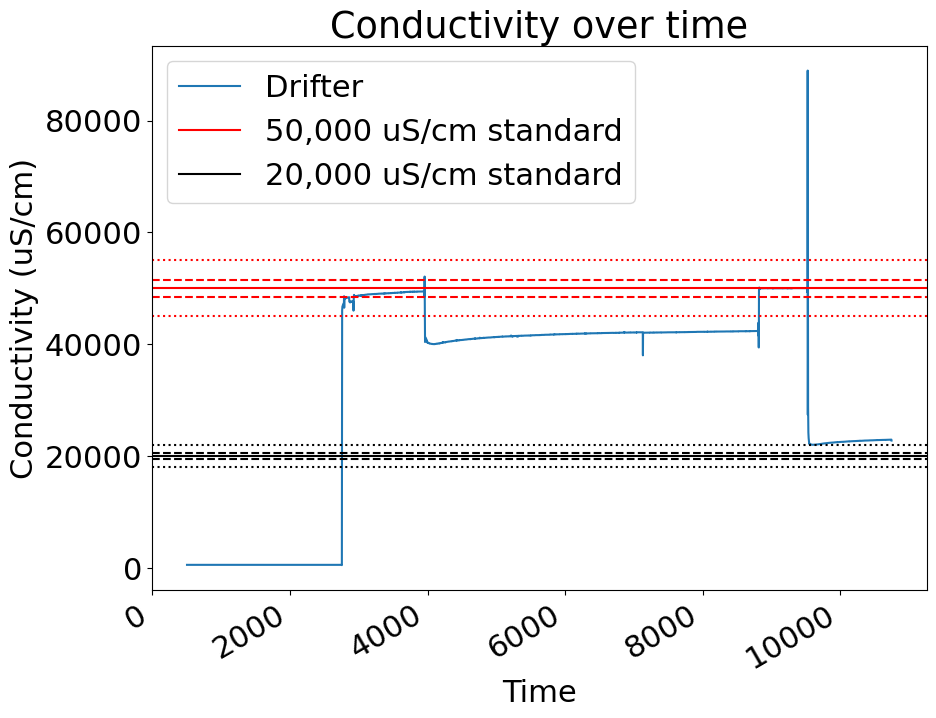

In [29]:
cond_slope = (acond)* 1.787 #calculated via 50,000 uS/cm divided by 29,075.85

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time, cond_slope, label = 'Drifter')
plt.axhline( y = 50000, color = 'r', label = '50,000 uS/cm standard')
plt.axhline( y = 51500, color = 'r', linestyle = '--')
plt.axhline (y = 48500, color = 'r', linestyle = '--')
plt.axhline (y = 45000, color = 'r', linestyle = ':')
plt.axhline (y = 55000, color = 'r', linestyle = ':')
plt.axhline( y = 20000, color = 'k', label = '20,000 uS/cm standard')
plt.axhline( y = 20600, color = 'k', linestyle = '--')
plt.axhline (y = 19400, color = 'k', linestyle = '--')
plt.axhline (y = 18000, color = 'k', linestyle = ':')
plt.axhline (y = 22000, color = 'k', linestyle = ':')

#plt.plot(YSItime,YSIcond, label = 'YSI EXO2s')
plt.title('Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()

In [19]:
### YSI vs Drifter correlation
YSIcond_reduced = YSIcond[::2]

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (5,4)) # PJB: explicitly create graph objects for subsequent access
plt.plot(acond,YSIcond_reduced, '.')

plt.title('Drifter vs YSI Conductivity')
plt.xlabel('Drifter')
plt.ylabel('YSI')


NameError: name 'YSIcond' is not defined

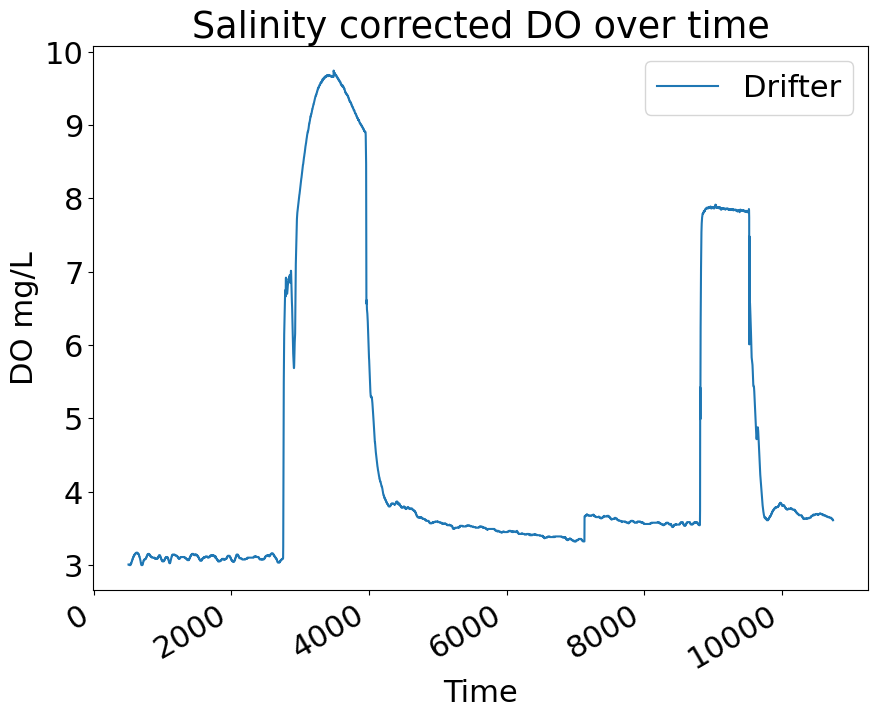

In [37]:
###DO with salinity correction
Sal = (0.7317 * (acond/1000)) - 3.7635
k = 0.85
DOsal = DO * k


plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,DOsal, label = 'Drifter')
#plt.plot(YSItime,YSIDO, label = 'YSI EXO2s')
plt.title('Salinity corrected DO over time')
plt.xlabel('Time')
plt.ylabel('DO mg/L')
axs.legend()
fig.autofmt_xdate()